In [ ]:
# install kagglehub
!pip install kagglehub


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


GET AND CHECK DATA

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("darshue/extracted-images")
print("Path to dataset files:", path)

100%|██████████| 3.40G/3.40G [00:33<00:00, 108MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/darshue/extracted-images/versions/19


If you're training the model using colab use the bottom  command to install the datasets. You'll need your kaggle api key which you can generate in your account settings at kaggle. Download the api key and paste the key when prompted to download the dataset

In [ ]:
#Run this command only if using Colab
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/darshue/extracted-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abielkim
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/darshue/extracted-images


The code below checks if youre dataset has been installed at the correct path

In [ ]:
import os

#check if running colab
is_colab = True
if is_colab:
    data_dir = './extracted-images/train/'
else:
    data_dir = "../data/train/"

# if images were downloaded and extracted properly, will print true and list the 5 sub classes
print("Path exists:", os.path.exists(data_dir))
print("Contents:", os.listdir(data_dir)) 

output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

Path exists: True
Contents: ['LGSC', 'CC', 'MC', 'HGSC', 'EC']


IMPORTS AND DEVICE

In [ ]:
import torch
import os
import os.path
import numpy as np
import sys
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed_all(111)

In [ ]:
# Checks if GPU is available if not uses CPU
if torch.cuda.is_available():
    print("CUDA available")
    device = torch.device("cuda")
else:
    print("CUDA not available")
    device = torch.device("cpu")
print("Device: ", device)

CUDA available
Device:  cuda


In [ ]:
# Ratio of the dataset to use for training (80% train, 20% test)
train_test_split = 0.8

# Number of samples per batch during training
batch_size = 32

# Total number of times the entire training dataset will be passed through the model
num_epochs = 25

# Learning rate used by the optimizer to update weights
learning_rate = 0.001

# Number of output classes 5 in our case 
num_classes = 5

# Number of subprocesses to use for data loading
# If running in Google Colab, use more workers; otherwise, use 1 to avoid system issues
if is_colab:
    num_workers = 4
else:
    num_workers = 1


In [ ]:
# Mean pixel Value and Standard Deviation for each RBG channel 
mean = [0.8078, 0.6700, 0.8138]
std = [0.0925, 0.1142, 0.0710]

In [ ]:
# Transformations applied to the training dataset
train_transform = transforms.Compose([
    transforms.Resize((496, 496)),
    transforms.RandomCrop(480),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms
    .Normalize(mean, std)
])
## Transformations applied to the training dataset
test_transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize((496, 496)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
#########################################
### PATCH 1: DATA PREPROCESSING LAYER ###
#########################################

# Loads training and test dataset using ImageFoler class
train_base_dataset = datasets.ImageFolder(root=os.path.join(data_dir))
test_base_dataset = datasets.ImageFolder(root=os.path.join(data_dir))

# Create a list of indices for the entire training dataset and calculate the split sizes
# Split the dataset into training and testing samples based on the train_test_split ratio
full_indices = list(range(len(train_base_dataset)))
train_size = int(train_test_split * len(train_base_dataset))
test_size = len(test_base_dataset) - train_size

# Shuffle the indices randomly to ensure a random split between training and testing datasets
import random
random.shuffle(full_indices)

# Split the indices into training and testing sets based on the calculated sizes
train_indices = full_indices[:train_size]
test_indices = full_indices[train_size:]

# Create subsets of the original dataset using the split indices for training and testing
train_dataset = torch.utils.data.Subset(train_base_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_base_dataset, test_indices)

# Explicitly set each transform separately to prevent data leakage
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

# Creates DataLoader for the training and testing datsets respectively. 
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Prints the number of samples in both datasets
print('Number of training samples:', len(train_loader.dataset))
print('Number of testing samples:', len(test_loader.dataset))

# Defines the classes for classification
classes = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']


Number of training samples: 20402
Number of testing samples: 5101


In [ ]:
# Create a transform to resize images to 496x496 pixels and convert to tensort format

if False:
    mean_transform = transforms.Compose([
        transforms.Resize((496, 496)),
        transforms.ToTensor()
    ])


    ###############
    ### PATCH 2 ###
    ###############
    
    #Load the dataset with transformations to compute mean and std 
    train_dataset_for_stats = datasets.ImageFolder(root=os.path.join(data_dir), transform=mean_transform)

    # Subset the dataset to only include images from the train dataset
    train_dataset_for_stats = torch.utils.data.Subset(train_dataset_for_stats, train_dataset.indices)

    # Create a DataLoader for the stats dataset
    train_loader_for_stats = DataLoader(train_dataset_for_stats, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    # initialize mean std values and # of samples counter
    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0

    # Loop through dataset calculating the mean and std per channel
    for images, _ in train_loader_for_stats:
        batch_samples = images.size(0)
        images = images.view(batch_samples, 3, -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    
    # Get average mean and std values over all samples
    mean /= nb_samples
    std /= nb_samples

    # Output the computed means
    print('Mean:', mean)
    print('Std:', std)

In [ ]:
# Import pre trained ResNEt18 model from torchvision
from torchvision.models import resnet18

# Load the model and move it the specific device GPU/CPU for training
model = resnet18(pretrained=True)
model = model.to(device)

# Create directory to save the models
models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)

# Defines path where model will be saved
model_save_path = os.path.join(models_dir, 'best_model.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Define the loss function 
criterion = nn.CrossEntropyLoss()

# Setup Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00025)

# Setup learning rate scheduler using CosineAnnealingLR
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
# Stores values required for plotting
epoch_losses = []
val_accuracies = []
test_accuracies = []

# Variables used to save our best model based on validation accuracy
best_val_accuracy = 0.0
best_epoch = 0

# Begin training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    # Training Loop with tqdm for progress tracking
    loop = tqdm.tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    scheduler.step() # Update the learning rate using the learning rate scheduler after each epoch
    epoch_loss = running_loss / len(train_loader) # Calculate average loss for the epoch
    epoch_losses.append(epoch_loss) # Store the loss for plotting

    # Validation Accuray Calculation
    model.eval() # Set the model to evaluation mode (disables dropout and batch norm
    correct = 0
    total = 0
    with torch.no_grad():
        val_loop = tqdm.tqdm(test_loader, desc="Validation")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item() # Count correct predictions
            total += labels.size(0) 
    val_accuracy = correct / total # Calculate validation accuracy
    val_accuracies.append(val_accuracy) # Store validation accuracy for plotting

    # Test Accuray Calculation
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct_test += (predictions == labels).sum().item() # Count correct predictions
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test # Calculate test accuracy
    test_accuracies.append(test_accuracy) # Store test accuracy for plotting

    # Print the epoch summary: loss, validation accuracy, and test accuracy
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Save the model if the current validation accuracy is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved new best model at epoch {epoch+1}")

Validation: 100%|██████████| 160/160 [00:16<00:00,  9.74it/s]


Epoch 1/25, Loss: 0.7621, Validation Accuracy: 0.7679, Test Accuracy: 0.7679
Saved new best model at epoch 1


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.87it/s]


Epoch 2/25, Loss: 0.4776, Validation Accuracy: 0.7285, Test Accuracy: 0.7285


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.76it/s]


Epoch 3/25, Loss: 0.4033, Validation Accuracy: 0.8606, Test Accuracy: 0.8606
Saved new best model at epoch 3


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.87it/s]


Epoch 4/25, Loss: 0.3752, Validation Accuracy: 0.8922, Test Accuracy: 0.8922
Saved new best model at epoch 4


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.77it/s]


Epoch 5/25, Loss: 0.3440, Validation Accuracy: 0.7075, Test Accuracy: 0.7075


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.85it/s]


Epoch 6/25, Loss: 0.3144, Validation Accuracy: 0.9359, Test Accuracy: 0.9359
Saved new best model at epoch 6


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.85it/s]


Epoch 7/25, Loss: 0.2822, Validation Accuracy: 0.8920, Test Accuracy: 0.8920


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.83it/s]


Epoch 8/25, Loss: 0.2629, Validation Accuracy: 0.8904, Test Accuracy: 0.8904


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.82it/s]


Epoch 9/25, Loss: 0.2359, Validation Accuracy: 0.8704, Test Accuracy: 0.8704


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.80it/s]


Epoch 10/25, Loss: 0.2073, Validation Accuracy: 0.9555, Test Accuracy: 0.9555
Saved new best model at epoch 10


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.88it/s]


Epoch 11/25, Loss: 0.1879, Validation Accuracy: 0.9298, Test Accuracy: 0.9298


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.66it/s]


Epoch 12/25, Loss: 0.1588, Validation Accuracy: 0.9514, Test Accuracy: 0.9514


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.70it/s]


Epoch 13/25, Loss: 0.1561, Validation Accuracy: 0.9488, Test Accuracy: 0.9488


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.71it/s]


Epoch 14/25, Loss: 0.1311, Validation Accuracy: 0.9751, Test Accuracy: 0.9751
Saved new best model at epoch 14


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.80it/s]


Epoch 15/25, Loss: 0.1135, Validation Accuracy: 0.9714, Test Accuracy: 0.9714


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.94it/s]


Epoch 16/25, Loss: 0.1043, Validation Accuracy: 0.9720, Test Accuracy: 0.9720


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.80it/s]


Epoch 17/25, Loss: 0.0859, Validation Accuracy: 0.9782, Test Accuracy: 0.9782
Saved new best model at epoch 17


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.79it/s]


Epoch 18/25, Loss: 0.0722, Validation Accuracy: 0.9835, Test Accuracy: 0.9835
Saved new best model at epoch 18


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.73it/s]


Epoch 19/25, Loss: 0.0627, Validation Accuracy: 0.9886, Test Accuracy: 0.9886
Saved new best model at epoch 19


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.84it/s]


Epoch 20/25, Loss: 0.0516, Validation Accuracy: 0.9875, Test Accuracy: 0.9875


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.82it/s]


Epoch 21/25, Loss: 0.0428, Validation Accuracy: 0.9920, Test Accuracy: 0.9920
Saved new best model at epoch 21


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.74it/s]


Epoch 22/25, Loss: 0.0413, Validation Accuracy: 0.9922, Test Accuracy: 0.9922
Saved new best model at epoch 22


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.79it/s]


Epoch 23/25, Loss: 0.0310, Validation Accuracy: 0.9931, Test Accuracy: 0.9931
Saved new best model at epoch 23


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.65it/s]


Epoch 24/25, Loss: 0.0279, Validation Accuracy: 0.9935, Test Accuracy: 0.9935
Saved new best model at epoch 24


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.72it/s]


Epoch 25/25, Loss: 0.0265, Validation Accuracy: 0.9943, Test Accuracy: 0.9943
Saved new best model at epoch 25


Plot saved to: ../output/training_validation_plot.png


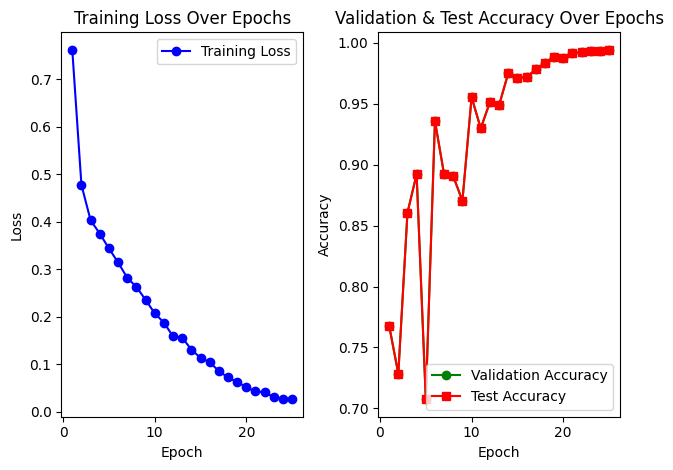

In [35]:
plt.figure()

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', linestyle='-', color='g', label="Validation Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', linestyle='-', color='r', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation & Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "training_validation_plot.png")
plt.savefig(plot_path)
print("Plot saved to:", plot_path)

plt.show()

Total Accuracy: 0.9943148402274063


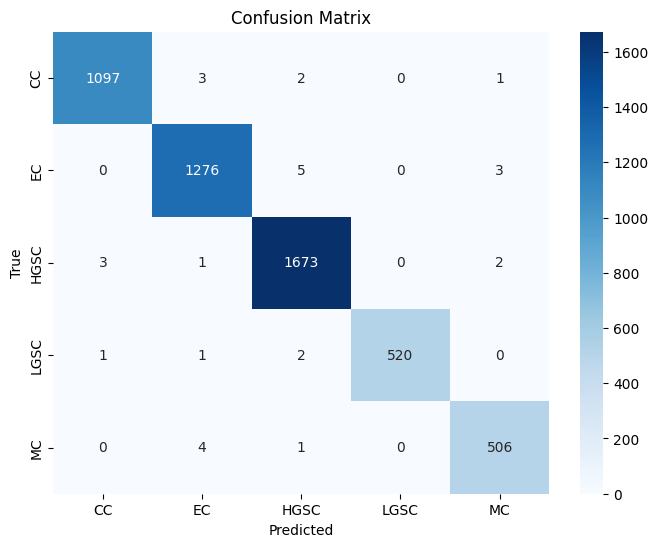

In [ ]:
# Load the saved model's state_dict (weights) into the model and move it to the appropriate device GPU/CPU
state_dict = torch.load(model_save_path, map_location=device)
model.load_state_dict(state_dict)

# Set the model to evaluation mod
model.eval()

# Lists to store all predictions and true labels for confusion matrix calculation
all_preds = []
all_labels = []


with torch.no_grad():
    # Loop through the test dataset to collect predictions and true labels
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images) # Get model outputs
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)  # Add predictions to the list
        all_labels.extend(labels.cpu().numpy()) # Add true labels to the list

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Calculate the overall accuracy
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print("Total Accuracy:", accuracy)

# Define the class labels for the confusion matrix plot
classes = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']

# Plot confusion matrix 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()